In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-859.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-158.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10121.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1811.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-97.png
/kaggle/input/covid19

In [7]:
# Install dependencies
!pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn

✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - accuracy: 0.5738 - loss: 1.1570 - val_accuracy: 0.6541 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.6781 - loss: 0.8163 - val_accuracy: 0.7498 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.7072 - loss: 0.7625 - val_accuracy: 0.7919 - val_loss: 0.5516 - learning_rate: 1.0000e-04
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.7425 - loss: 0.6908 - val_accuracy: 0.8112 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.7662 - loss: 0.6259 - val_accuracy: 0.7541 - val_loss: 0.6436 - learning_rate: 1.0000e-04
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.7762 - loss: 0.5964 - val_accuracy: 0.7791 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accurac

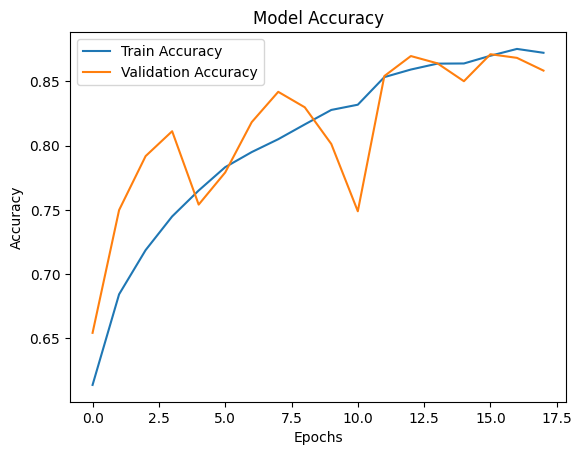

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [3]:
# Import Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision for Faster Training on GPU
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# ✅ Check if GPU is Available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU Available:", gpus)
else:
    print("⚠ No GPU detected, training will be slower.")

# Define dataset paths
DATASET_PATH = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
CATEGORIES = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
IMG_SIZE = 128  # Smaller size for faster training

# Function to Load Images
def load_images(category, label):
    images, labels = [], []
    images_path = os.path.join(DATASET_PATH, category, "images")
    
    if not os.path.exists(images_path):
        print(f"⚠ Directory not found: {images_path}")
        return images, labels
        
    for img_name in os.listdir(images_path):
        img_path = os.path.join(images_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠ Skipping invalid image: {img_path}")
            continue  

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)
        labels.append(label)
    
    return images, labels

# Load dataset
all_images, all_labels = [], []
for idx, category in enumerate(CATEGORIES):
    imgs, lbls = load_images(category, idx)
    all_images.extend(imgs)
    all_labels.extend(lbls)

# Convert to NumPy arrays
X = np.array(all_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(all_labels)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# ✅ Build Optimized CNN Model for GPU
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(len(CATEGORIES), activation='softmax', dtype='float32')  # ✅ Ensuring correct dtype for mixed precision
])

# ✅ Compile Model with GPU-Optimized AdamW Optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_cnn_model.keras", monitor="val_accuracy", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# ✅ Train Model on GPU
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# ✅ Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# ✅ Function to Test Model on New X-rays
def predict_xray(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    print(f"Prediction: {CATEGORIES[class_idx]} (Confidence: {prediction[0][class_idx]*100:.2f}%)")

# Example Prediction
predict_xray("/path/to/test_xray.png", model)
